In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# **Load the dataset**

IMDB movies review dataset is the dataset for binary sentiment classification containing 25,000 highly polar movie reviews for training, and 25,000 for testing. This dataset can be acquired from this website or we can also use tensorflow_datasets library to acquire it.

In [ ]:
# Obtain the imdb review dataset from tensorflow datasets
dataset = tfds.load('imdb_reviews', as_supervised=True)

# Seperate test and train datasets
train_dataset, test_dataset = dataset['train'], dataset['test']

# Split the test and train data into batches of 32
# and shuffling the training set
batch_size = 32
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9HXAFI/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9HXAFI/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9HXAFI/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])


Text:
 b'Deeply humorous yet honest comedy about a bunch of grownups (Bill Paxton, Julie Warner, Kevin Pollak, Elizabeth Perkins, Vincent Spano, Matt Craven, and Diane Lane) who are invited back to spend a week to Tomawka, a camp in (Ontario) Canada by their former consuelor (Alan Arkin). Writer/director Mike Binder drew upon his experience at the same camp as the main source of creating a gentle and understanding yarn that makes sense. Also, the movie has plenty of funny moments, some of which are completely bizarre like my favorite, the one involves using masking tape. Newton Thomas Sigel ("The Usual Suspects", "Three Kings") provides the film with some impressive shots of the Canadian wilderness. Among the cast, Sam Raimi, director of "THE EVIL DEAD" films and "The Gift", appears here as Arkin\'s bumbling right-hand man. One more thing, this film reassured me that a camp doesn\'t have to be a site of bloody murders.'

Label:  1


# **Build the Model**

In this section, we will define the model we will use for sentiment analysis. The initial layer of this architecture is the text vectorization layer, responsible for encoding the input text into a sequence of token indices. These tokens are subsequently fed into the embedding layer, where each word is assigned a trainable vector. After enough training, these vectors tend to adjust themselves such that words with similar meanings have similar vectors. This data is then passed to RNN layers which process these sequences and finally convert it to a single logit as the classification output.

# **Text Vectorization**

We will first perform text vectorization and let the encoder map all the words in the training dataset to a token. We can also see in the example below how we can encode and decode the sample review into a vector of integers.

In [ ]:
# Using the TextVectorization layer to normalize, split, and map strings
# to integers.
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text, _: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)


original:  b'Deeply humorous yet honest comedy about a bunch of grownups (Bill Paxton, Julie Warner, Kevin Pollak, Elizabeth Perkins, Vincent Spano, Matt Craven, and Diane Lane) who are invited back to spend a week to Tomawka, a camp in (Ontario) Canada by their former consuelor (Alan Arkin). Writer/director Mike Binder drew upon his experience at the same camp as the main source of creating a gentle and understanding yarn that makes sense. Also, the movie has plenty of funny moments, some of which are completely bizarre like my favorite, the one involves using masking tape. Newton Thomas Sigel ("The Usual Suspects", "Three Kings") provides the film with some impressive shots of the Canadian wilderness. Among the cast, Sam Raimi, director of "THE EVIL DEAD" films and "The Gift", appears here as Arkin\'s bumbling right-hand man. One more thing, this film reassured me that a camp doesn\'t have to be a site of bloody murders.'
encoded:  [1622 1941  241 1189  220   43    4  738    5    1  

In [ ]:
# Creating the model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
# Training the model and validating it on test set
history = model.fit(
    train_dataset,
    epochs=2,
    validation_data=test_dataset,
)

Epoch 1/2
782/782 [==============================] - 2071s 3s/step - loss: 0.4020 - accuracy: 0.8087 - val_loss: 0.3490 - val_accuracy: 0.8396
Epoch 2/2
782/782 [==============================] - 2038s 3s/step - loss: 0.2362 - accuracy: 0.9039 - val_loss: 0.3287 - val_accuracy: 0.8540


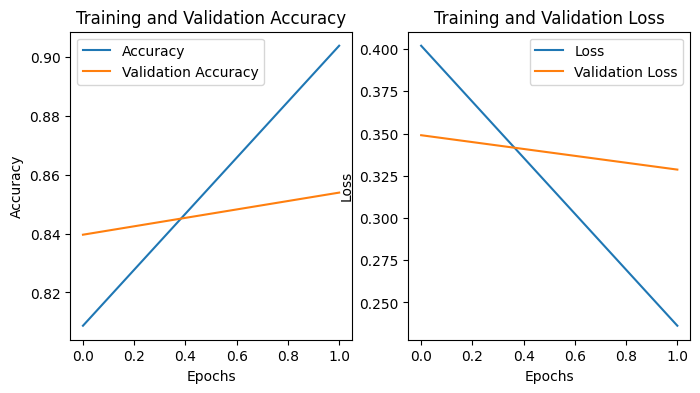

In [ ]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

MAKE THE EPOCHS AS 5 AND TRY WHETHER THE ACCURACY IS BETTER


You should get some thing like shown below.. a better accuracy!



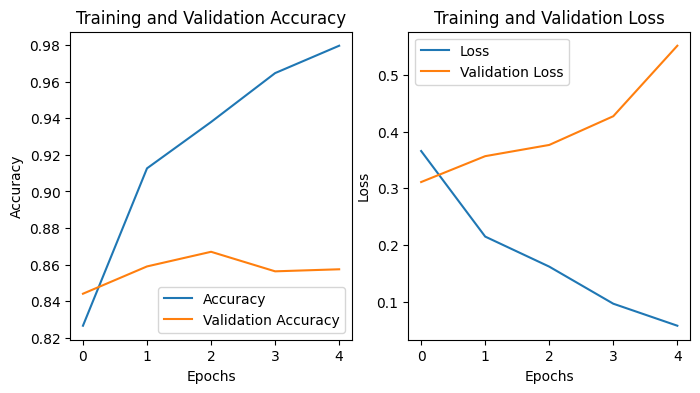

In [ ]:
# Making predictions
sample_text = (
    '''The movie How to Train a Dragon was so good and the animation are so dope.
    I would recommend my friends to watch it.'''
)
predictions = model.predict(np.array([sample_text]))
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
    print('The review is positive')
else:
    print('The review is negative')

1/1 [==============================] - 0s 44ms/step
0.5442124
The review is positive


In [ ]:
# Making predictions
sample_text = (
    '''The movie lord of ring series are good , however, they made the latter series not that impressive'''
)
predictions = model.predict(np.array([sample_text]))
print(*predictions[0])

# Print the label based on the prediction
if predictions[0] > 0:
    print('The review is positive')
else:
    print('The review is negative')

1/1 [==============================] - 0s 50ms/step
-0.11670618
The review is negative


[Reference](https://www.geeksforgeeks.org/rnn-for-text-classifications-in-nlp/)